# Analiza średnich temperatur dziennych w Madrycie

średnich temperatur dziennych analiza madrycka

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from statsmodels.tsa.stattools import acf, acovf

## Przygotowanie danych

In [39]:
data_path_madrid = 'madrid.csv'
madrid_data = pd.read_csv(data_path_madrid)

madrid_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Europe,Spain,NaN,Madrid,5,13,2017,61.0
1,Europe,Spain,NaN,Madrid,5,14,2017,63.2
2,Europe,Spain,NaN,Madrid,5,15,2017,66.8
3,Europe,Spain,NaN,Madrid,5,16,2017,73.7
4,Europe,Spain,NaN,Madrid,5,17,2017,72.3


Na tym etapie stwierdzamy, że `Region`, `Country` i `State` nie są nam potrzebne

In [40]:
madrid_data = madrid_data.drop('Region', axis=1)
madrid_data = madrid_data.drop('Country', axis=1)
madrid_data = madrid_data.drop('State', axis=1)

madrid_data

,City,Month,Day,Year,AvgTemperature
0,Madrid,5,13,2017,61.0
1,Madrid,5,14,2017,63.2
2,Madrid,5,15,2017,66.8
3,Madrid,5,16,2017,73.7
4,Madrid,5,17,2017,72.3
...,...,...,...,...,...
1092,Madrid,5,9,2020,67.0
1093,Madrid,5,10,2020,60.1
1094,Madrid,5,11,2020,60.6
1095,Madrid,5,12,2020,55.3


`Month`, `Day`, `Year` i `AvgTemperature` to liczby

In [41]:
madrid_data["Month"] = pd.to_numeric(madrid_data["Month"])
madrid_data["Day"] = pd.to_numeric(madrid_data["Day"])
madrid_data["Year"] = pd.to_numeric(madrid_data["Year"])
madrid_data["AvgTemperature"] = pd.to_numeric(madrid_data["AvgTemperature"])

Coś tam z datą 

In [42]:
madrid_data['Date'] = pd.to_datetime(madrid_data[['Year', 'Month', 'Day']])

madrid_data = madrid_data.sort_values(by='Date')

madrid_data

,City,Month,Day,Year,AvgTemperature,Date
0,Madrid,5,13,2017,61.0,2017-05-13
1,Madrid,5,14,2017,63.2,2017-05-14
2,Madrid,5,15,2017,66.8,2017-05-15
3,Madrid,5,16,2017,73.7,2017-05-16
4,Madrid,5,17,2017,72.3,2017-05-17
...,...,...,...,...,...,...
1092,Madrid,5,9,2020,67.0,2020-05-09
1093,Madrid,5,10,2020,60.1,2020-05-10
1094,Madrid,5,11,2020,60.6,2020-05-11
1095,Madrid,5,12,2020,55.3,2020-05-12


Zobaczmy jak dane się prezentują na wykresie

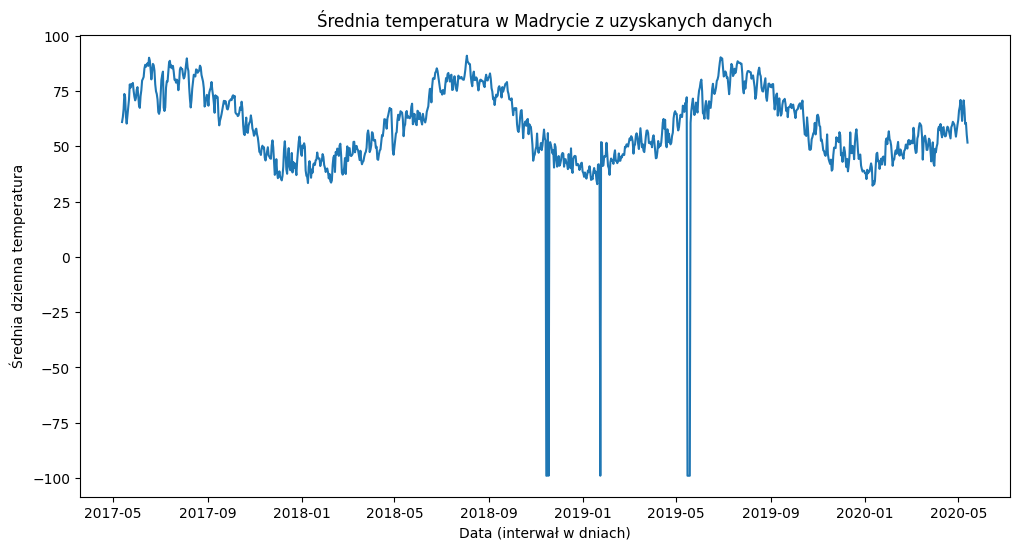

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'])

plt.title('Średnia temperatura w Madrycie z uzyskanych danych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.show()

### Brakujące wartości

Widzimy teraz pewne problemy. W uzyskanych danych badacze nie zmierzeli danych dla wybranych konkretnych przypadkowych dni co powoduje problem.

Dodatkowo temperatura jest prawdopodobnie w Farenheitach 

In [44]:
madrid_data[madrid_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date
550,Madrid,11,14,2018,-99.0,2018-11-14
551,Madrid,11,15,2018,-99.0,2018-11-15
553,Madrid,11,17,2018,-99.0,2018-11-17
620,Madrid,1,23,2019,-99.0,2019-01-23
733,Madrid,5,16,2019,-99.0,2019-05-16


hahahhahhahahahhah

Potwierdza się hipoteza, `-99` to wartość kiedy prawdopodobnie temp. nie została zmierzona bo mija się to z prawdą. Zmienimy je na średnią z 5 sasiądujących dni.
`brakujący dzień = 1/4 (-2 dzień + -1 dzień + +1 dzień + +2dzień)`

In [45]:
madrid_data['AvgTemperature_New'] = madrid_data['AvgTemperature']

for i in range(len(madrid_data)):
    if madrid_data.at[i, 'AvgTemperature'] == -99.0:
        start_index = max(0, i - 2)
        end_index = min(len(madrid_data), i + 2)
        neighbors = madrid_data['AvgTemperature'].loc[start_index:end_index]
        neighbors_without_minus_99 = neighbors[neighbors != -99.0]
        madrid_data.at[i, 'AvgTemperature_New'] = round(neighbors_without_minus_99.mean(), 2)

madrid_data['AvgTemperature'] = madrid_data['AvgTemperature_New']
madrid_data = madrid_data.drop('AvgTemperature_New', axis=1)

madrid_data[madrid_data.AvgTemperature < -75].head()

,City,Month,Day,Year,AvgTemperature,Date


Puste wiersze z złymi danymi => więc się zgadza. 

Zobaczmy wykres po tych modyfikacjach

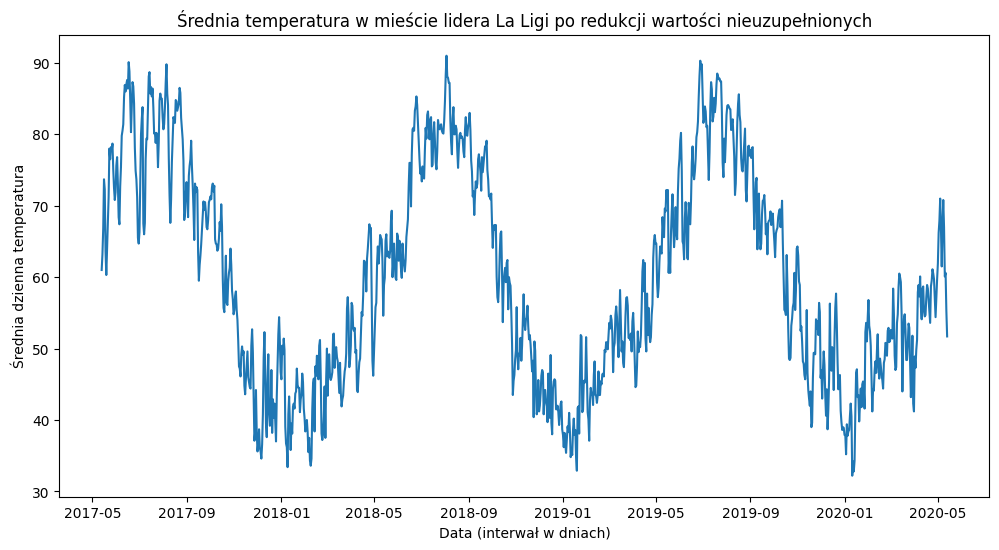

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'])

plt.title('Średnia temperatura w mieście lidera La Ligi po redukcji wartości nieuzupełnionych')

plt.xlabel('Data (interwał w dniach)')
plt.ylabel('Średnia dzienna temperatura')

plt.show()

### Konwersja stopni

Wartości są mniej niepokojące, jednak 90 stopni nie jest możliwe. Zauważmy że $100$ stopni Farenheita to $37.7$ Celcjusza co miałoby większy sens ale maksimum.

Wzór konwersji z Farenheita na Celsjusza to:
$$
(F - 32) \cdot \frac{5}{9}
$$

In [47]:
def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * (5/9)


madrid_data['AvgTemperature'] = madrid_data['AvgTemperature'].apply(fahrenheit_to_celsius)

Ponownie spójrzmy na wykres

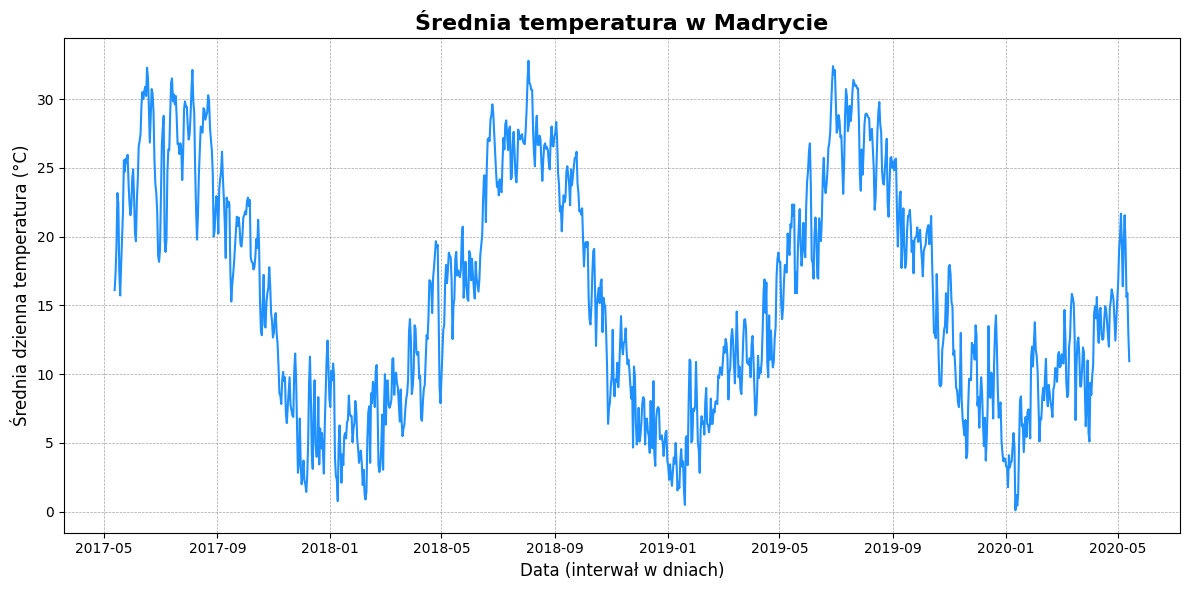

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(madrid_data['Date'], madrid_data['AvgTemperature'], color='dodgerblue', linewidth=1.5)

plt.title('Średnia temperatura w Madrycie', fontsize=16, fontweight='bold')

plt.xlabel('Data (interwał w dniach)', fontsize=12)
plt.ylabel('Średnia dzienna temperatura (°C)', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

Takie dane wyglądają jak najbadziej sensownie i realnie - mamy więc z czym pracować.

# Zbadanie jakości danych

Średnia: 15.597412134103108
Odchylenie standardowe: 8.263092461953267
Mediana: 14.666666666666666
Liczba obserwacji: 1097
Minimum: 0.1111111111111127
Maksimum: 32.77777777777778


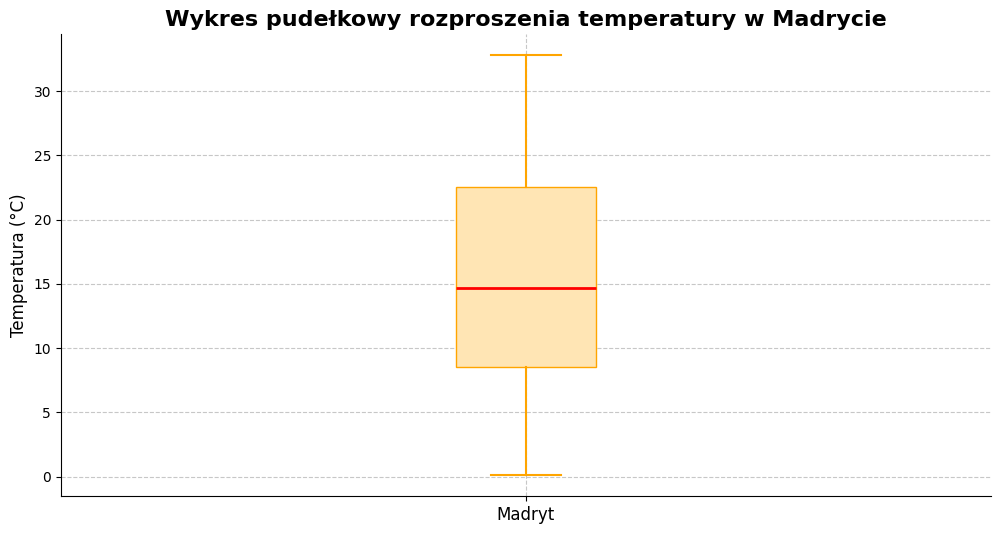

In [49]:
data = madrid_data['AvgTemperature']
srednia = np.mean(data)
odchylenie = np.std(data)
mediana = np.median(data)
ilosc_danych = len(data)
minimum = np.min(data)
maksimum = np.max(data)

print(f"Średnia: {srednia}")
print(f"Odchylenie standardowe: {odchylenie}")
print(f"Mediana: {mediana}")
print(f"Liczba obserwacji: {ilosc_danych}")
print(f"Minimum: {minimum}")
print(f"Maksimum: {maksimum}")


plt.figure(figsize=(12, 6))

box = plt.boxplot(
    data, 
    patch_artist=True, 
    boxprops=dict(facecolor='#ffe5b4', color='orange'), 
    whiskerprops=dict(color='orange', linewidth=1.5), 
    capprops=dict(color='orange', linewidth=1.5), 
    medianprops=dict(color='red', linewidth=2)
)

plt.title('Wykres pudełkowy rozproszenia temperatury w Madrycie', fontsize=16, fontweight='bold')
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.xticks(ticks=[1], labels=['Madryt'], fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

# Autokowariancja i autokorelacja empiryczna dla surowych danych:

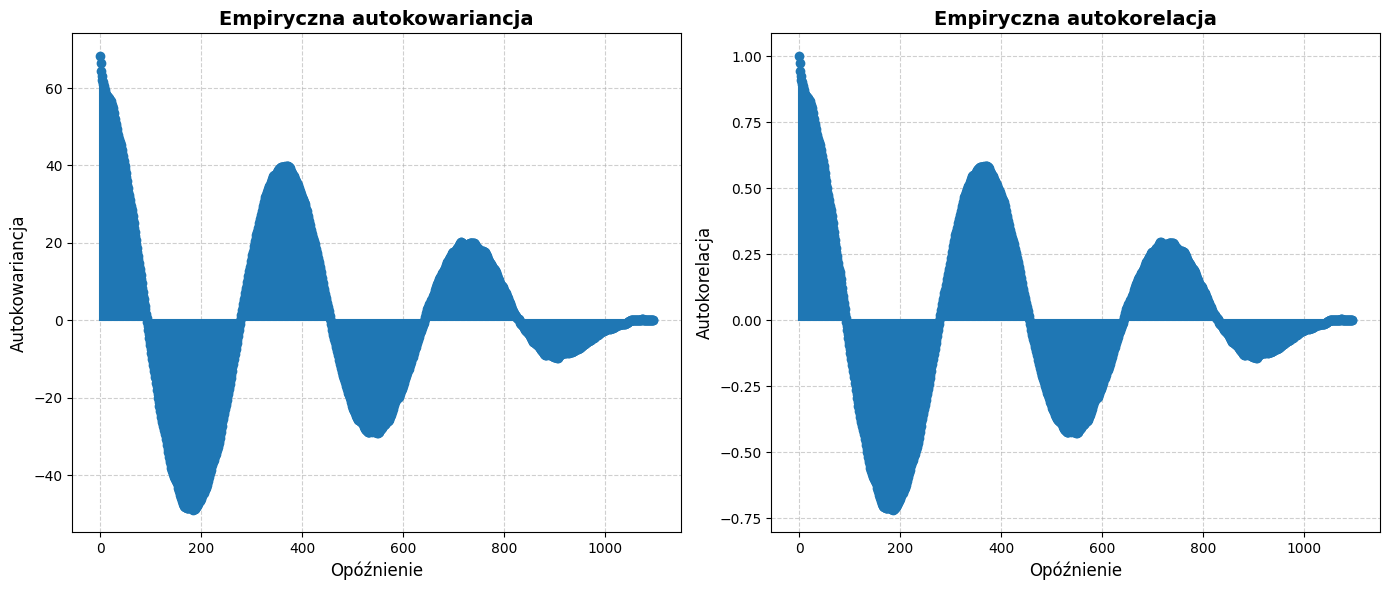

In [50]:
h_max = len(data)
acvf_emp = acovf(data, fft=True)
acf_emp = acf(data, fft=True, nlags=h_max)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.stem(acvf_emp, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('Autokowariancja',fontsize=12)
plt.title('Empiryczna autokowariancja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')

plt.subplot(1, 2, 2)
plt.stem(acf_emp, basefmt='')
plt.xlabel('Opóźnienie',fontsize=12)
plt.ylabel('Autokorelacja',fontsize=12)
plt.title('Empiryczna autokorelacja', fontsize=14, fontweight='bold')
plt.grid(alpha=0.6, linestyle='--')

plt.tight_layout()
plt.show()


tu wersja od chatu:

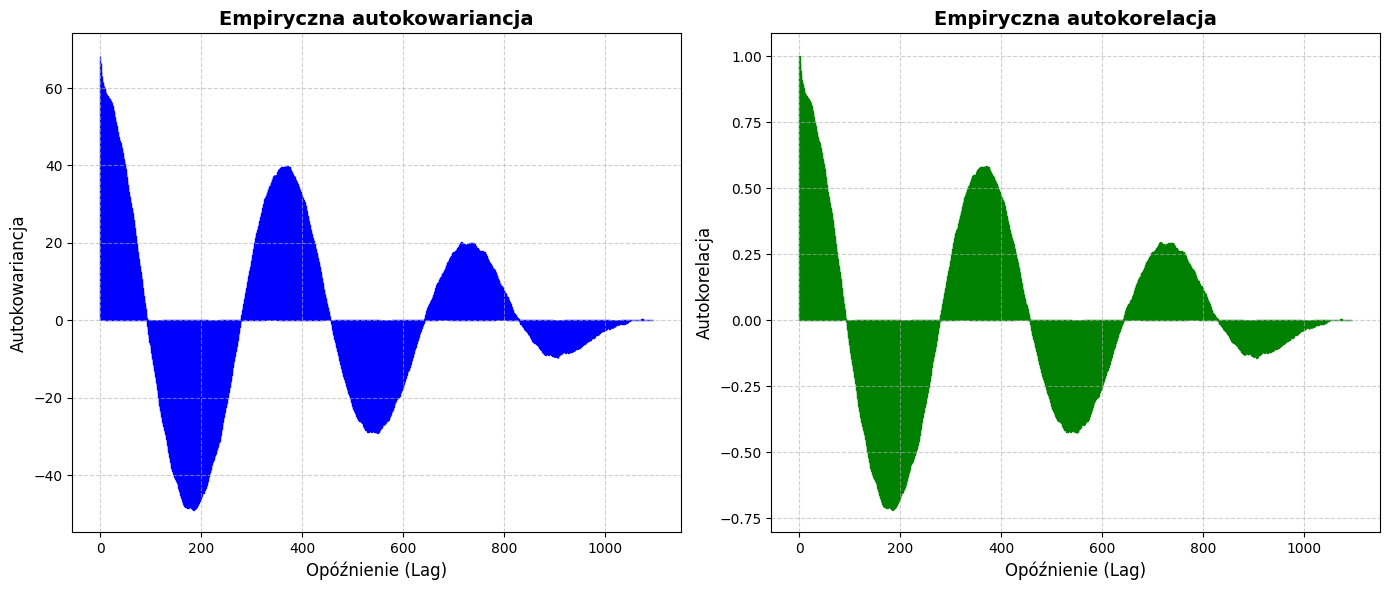

In [51]:
def autocovariance(data, lag):
    data = np.array(data)
    mean = np.mean(data)
    n = len(data)
    return np.sum((data[:n-lag] - mean) * (data[lag:] - mean)) / n

lags = range(len(data)) 
autokowariancje = [autocovariance(data, lag) for lag in lags]
autokorelacje = acf(data, fft=True, nlags=len(data) - 1)

# Tworzenie wykresów
plt.figure(figsize=(14, 6))

# Wykres autokowariancji
plt.subplot(1, 2, 1)
plt.bar(lags, autokowariancje, color='skyblue', edgecolor='blue')
plt.title('Empiryczna autokowariancja', fontsize=14, fontweight='bold')
plt.xlabel('Opóźnienie (Lag)', fontsize=12)
plt.ylabel('Autokowariancja', fontsize=12)
plt.grid(alpha=0.6, linestyle='--')

# Wykres autokorelacji
plt.subplot(1, 2, 2)
plt.bar(range(len(autokorelacje)), autokorelacje, color='lightgreen', edgecolor='green')
plt.title('Empiryczna autokorelacja', fontsize=14, fontweight='bold')
plt.xlabel('Opóźnienie (Lag)', fontsize=12)
plt.ylabel('Autokorelacja', fontsize=12)
plt.grid(alpha=0.6, linestyle='--')

# Wyświetlenie wykresów
plt.tight_layout()
plt.show()


Test ADF (Augmented Dickey-Fuller) w celu weryfikacji hipotezy o niestacjonarności danych czasowych

In [52]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

result = adfuller(madrid_data['AvgTemperature'].dropna())

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -1.939327084884461
p-value: 0.3137924614544682
Critical Values:
   1%: -3.436402509014354
   5%: -2.8642124318084456
   10%: -2.568192893555997


Interpretacja:
Porównanie ADF Statistic z wartościami krytycznymi:

1. Wartość statystyki  ADF=−1.9393 jest większa (mniej ujemna) niż wszystkie wartości krytyczne (
−3.4364, −2.8642, −2.5682). To sugeruje brak wystarczających dowodów na odrzucenie hipotezy zerowej.
2. p-value:
Wartość p=0.3138 jest większa niż typowy poziom istotności (0.05). Oznacza to, że nie możemy odrzucić hipotezy zerowej o niestacjonarności danych.

Wniosek: Dane są niestacjonarne. Aby móc zastosować model ARMA, należy przekształcić dane, by stały się stacjonarne. I po to kolejne kroki w raporcie.

No i teraz cykamy te metody, zad 4 z L5 bylo podobne do jej kodow i chyba dawalo ten sam efekt, więc bazujmy na jej kodzie do tego.

U niej bylo na sztywno wybrane jakies 0.1*t, wiec u nas musi byc dopasowane do danych, chat tak proponuje.

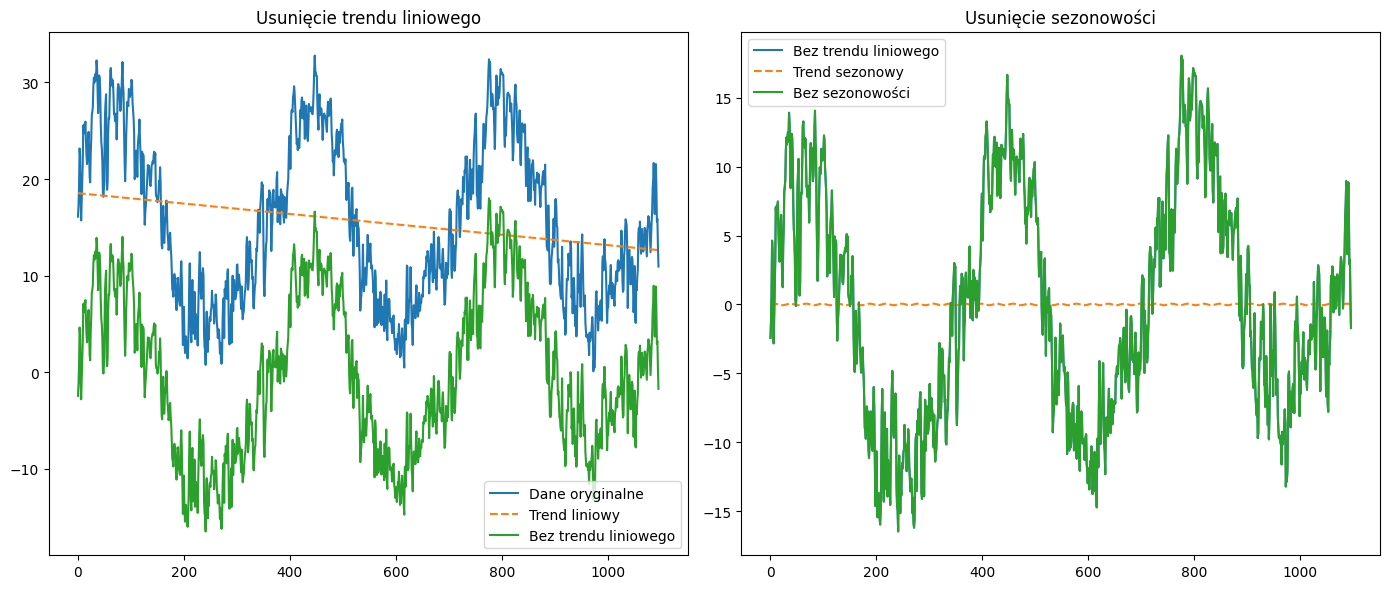

In [53]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# Dekompozycja trendu liniowego
time = np.arange(len(madrid_data))
temperature = madrid_data['AvgTemperature'].values

# Usuwanie trendu liniowego
linear_reg = LinearRegression()
linear_reg.fit(time.reshape(-1, 1), temperature)
trend_predicted = linear_reg.predict(time.reshape(-1, 1))
temperature_without_linear_trend = temperature - trend_predicted

# Usuwanie funkcji okresowej (sezonowości)
def sine_func(x, A, omega):
    return A * np.sin(omega * x)

p0 = [10, 2 * np.pi / 30]  # Początkowe wartości parametrów
params, _ = curve_fit(sine_func, time, temperature_without_linear_trend, p0=p0)
fitted_sine_wave = sine_func(time, *params)
temperature_without_seasonal = temperature_without_linear_trend - fitted_sine_wave

# Wykresy przed i po dekompozycji
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Wykres trendu liniowego
axes[0].plot(madrid_data['AvgTemperature'], label='Dane oryginalne')
axes[0].plot(trend_predicted, label='Trend liniowy', linestyle='--')
axes[0].plot(madrid_data.index, temperature_without_linear_trend, label='Bez trendu liniowego')
axes[0].set_title('Usunięcie trendu liniowego')
axes[0].legend()

# Wykres sezonowości
axes[1].plot(madrid_data.index, temperature_without_linear_trend, label='Bez trendu liniowego')
axes[1].plot(madrid_data.index, fitted_sine_wave, label='Trend sezonowy', linestyle='--')
axes[1].plot(madrid_data.index, temperature_without_seasonal, label='Bez sezonowości')
axes[1].set_title('Usunięcie sezonowości')
axes[1].legend()

plt.tight_layout()
plt.show()

#### metoda boxa coxa od razu z testem adf

In [ ]:
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

# 1. Różnicowanie danych
# Dane po usunięciu trendu liniowego i sezonowości
temperature_diff = np.diff(temperature_without_seasonal)

# 2. Transformacja Boxa-Coxa
# Dodajemy stałą, aby dane były dodatnie (wymóg transformacji Boxa-Coxa)
temperature_positive = temperature_without_seasonal - np.min(temperature_without_seasonal) + 1
temperature_boxcox, lambda_boxcox = boxcox(temperature_positive)

# 3. Test ADF po przekształceniach
adf_diff_result = adfuller(temperature_diff)
adf_boxcox_result = adfuller(temperature_boxcox)

# Wyniki testów ADF
adf_results = {
    "Po różnicowaniu": {
        "ADF Statistic": adf_diff_result[0],
        "p-value": adf_diff_result[1],
        "Critical Values": adf_diff_result[4]
    },
    "Po transformacji Boxa-Coxa": {
        "ADF Statistic": adf_boxcox_result[0],
        "p-value": adf_boxcox_result[1],
        "Critical Values": adf_boxcox_result[4]
    }
}

import ace_tools as tools; tools.display_dataframe_to_user(name="Wyniki testów ADF po przekształceniach", dataframe=pd.DataFrame(adf_results))
